In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Генерация кода по вопросам со StackOverflow


In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#from torchtext.datasets import Multi30k
from torchtext.legacy.datasets import TranslationDataset
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
import re

#place of possible hyperparameters (max_len)
def tokenize_question(text, max_len = 16):
    """
    Tokenizes question from a string into a list of strings (tokens) and reverses it
    tokenize_question('Omg, over_16_symbols_in_word, what does this code do?') -> 
    ['do', 'code', 'this', 'does', 'what', 'Omg']
    """
    return list(filter(lambda x: len(x) <= max_len, re.findall(r"[\w']+", text)[::-1]))

#place of possible hyperparameters (max_len)
def tokenize_snippet(text, max_len = 10):
    """
    Tokenizes code snippet into a list of operands
    tokenize_snippet("device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #dfgdfgdfgdfgdfgdfgdrg") ->
    ['device', '=', 'torch', '.', 'device', '(', "'cuda'", 'if', 'torch', '.', 'cuda', '.', '(', ')', 'else', "'cpu'", ')']
    """
    return list(filter(lambda x: len(x) <= max_len, re.findall(r"[\w']+|[.,!?;:@~(){}\[\]+-/=\\\'\"\`]", text)))

In [6]:
!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!mkdir ./stepik-dl-nlp/datasets/stackoverflow_code_generation/
!mkdir ./stepik-dl-nlp/datasets/stackoverflow_code_generation/conala/
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/stackoverflow_code_generation/conala/conala-train.csv" \
    -o ./stepik-dl-nlp/datasets/stackoverflow_code_generation/conala/conala-train.csv
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/stackoverflow_code_generation/conala/conala-valid.csv" \
    -o ./stepik-dl-nlp/datasets/stackoverflow_code_generation/conala/conala-valid.csv
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/stackoverflow_code_generation/conala/conala-test.csv" \
    -o ./stepik-dl-nlp/datasets/stackoverflow_code_generation/conala/conala-test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  176k  100  176k    0     0   421k      0 --:--:-- --:--:-- --:--:--  420k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33225  100 33225    0     0   138k      0 --:--:-- --:--:-- --:--:--  138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46790  100 46790    0     0   183k      0 --:--:-- --:--:-- --:--:--  183k


In [7]:
import pandas as pd
pd.read_csv('./stepik-dl-nlp/datasets/stackoverflow_code_generation/conala/conala-train.csv')

,intent,snippet
0,How to convert a list of multiple integers int...,"sum(d * 10 ** i for i, d in enumerate(x[::-1]))"
1,How to convert a list of multiple integers int...,"r = int(''.join(map(str, x)))"
2,how to convert a datetime string back to datet...,datetime.strptime('2010-11-13 10:33:54.227806'...
3,Averaging the values in a dictionary based on ...,"[(i, sum(j) / len(j)) for i, j in list(d.items..."
4,zip lists in python,"zip([1, 2], [3, 4])"
...,...,...
1995,how to open a url in python,webbrowser.open('http://example.com')
1996,PyQt QPushButton Background color,self.pushButton.setStyleSheet('background-colo...
1997,Zip and apply a list of functions over a list ...,"[x(y) for x, y in zip(functions, values)]"
1998,How do I modify the width of a TextCtrl in wxP...,"wx.TextCtrl(self, -1, size=(300, -1))"


In [8]:
import torch
from torchtext import data, datasets

#torchtext.legacy.data.Field - Defines a datatype together with instructions for converting to Tensor.
SRC = Field(
    tokenize = tokenize_question, #max_len = 16
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
    include_lengths = True
)

TRG = Field(
    tokenize = tokenize_snippet, #max_len = 10
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True
)

fields = {
    'intent': ('src', SRC),
    'snippet': ('trg', TRG)
}

#TabularDataset - Defines a Dataset of columns stored in CSV, TSV, or JSON format
#TabularDataset.splits - Create Dataset objects for multiple splits of a dataset.
train_data, valid_data, test_data = TabularDataset.splits(
                            path = './stepik-dl-nlp/datasets/stackoverflow_code_generation/conala/',
                            train = 'conala-train.csv',
                            validation = 'conala-valid.csv',
                            test = 'conala-test.csv',
                            format = 'csv',
                            fields = fields
)

In [9]:
#.build_vocab - Construct the Vocab object for this field from one or more datasets.
#place of possible hyperparameters (max_size=25000, min_freq=3)
SRC.build_vocab([train_data.src], max_size=25000, min_freq=3)
print(SRC.vocab.freqs.most_common(20))


#place of possible hyperparameters (max_size=?, min_freq=5)
TRG.build_vocab([train_data.trg], min_freq=5)
print(TRG.vocab.freqs.most_common(20))

print(f"Первые 10 токенов: {SRC.vocab.itos[:10]}")

print(f"Уникальные токены в словаре интентов: {len(SRC.vocab)}")
print(f"Уникальные токены в словаре сниппетов: {len(TRG.vocab)}")

[('a', 1285), ('in', 949), ('python', 922), ('to', 851), ('how', 633), ('of', 602), ('list', 558), ('string', 397), ('the', 328), ('from', 275), ('with', 228), ('pandas', 192), ('i', 191), ('dictionary', 162), ('get', 151), ('convert', 134), ('values', 131), ('do', 125), ('dataframe', 111), ('into', 110)]
[(')', 3480), ('(', 3475), ('.', 2595), (',', 1899), ('[', 1122), (']', 1121), ('=', 927), ("'", 885), ('\\', 697), (':', 587), ('in', 504), ('x', 498), ('"', 496), ('for', 450), ('1', 377), ('-', 279), ('a', 265), ('0', 259), ('/', 257), ('df', 234)]
Первые 10 токенов: ['<unk>', '<pad>', '<sos>', '<eos>', 'a', 'in', 'python', 'to', 'how', 'of']
Уникальные токены в словаре интентов: 613
Уникальные токены в словаре сниппетов: 398


In [10]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 2000
Размер валидационной выборки: 379
Размер тестовой выборки: 500


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_device(0)

In [12]:
device

device(type='cuda')

In [13]:
BATCH_SIZE = 200

'''
BucketIterator - Defines an iterator that batches examples of similar lengths together. (т.е. схожей длины, это суть выбора BucketIterator)
Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.

Итого, генерирует батчи тензоров равной длины (из индексов токенов), длина берется максимальная из примеров попавших в батч 
(если sort = True и/или sort_within_batch = True, то батчи формируются после предварительной сортировки по размеру), все примеры меньшей длины
добиваются до необходимой через токен паддинга (<pad>, id=1)

Судя по документации, sort_within_batch - отвечает только за необходимость сортировки внутри батчей, и не должен влиять на суть BucketIterator, 
а именно объединение в батчи на основе длины, но по факту влияет, если выставить False и не будет параметра sort = True, то примеры будут 
объединяться в батч рандомно, единственное, что дополнительно будет делать BucketIterator - это добивать до общей максимальной длины паддингами
(что бы убрать неоднозначности, явно добавил еще и параметр sort = True)

P.S. sort_within_batch нужно для упаковки PackedSequence, если батч не будет отсортирован по убыванию длины, то нужно при упаковке в 
PackedSequence, использовать параметр enforce_sorted = False (не изучал подробно на что это влияет)
'''
#place of possible hyperparameters (sort/sort_within_batch = True) - не факт что такое упорядочивание не скажется непонятным образом на обучении
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort = True,
     sort_within_batch = True, 
     sort_key = lambda x : len(x.src),
     device = device)

In [14]:
# temp_batch = next(iter(train_iterator))
# print(temp_batch)
# print('SRC:')
# print(temp_batch.src)
# print('TRG:')
# print(temp_batch.trg)
'''
Пример вывода:
[torchtext.legacy.data.batch.Batch of size 2]
	[.src]:('[torch.LongTensor of size 4x2]', '[torch.LongTensor of size 2]')
	[.trg]:[torch.LongTensor of size 10x2]
SRC:
(tensor([[  2,   2],
        [160, 168],
        [582, 399],
        [  3,   3]]), tensor([4, 4]))
TRG:
tensor([[  2,   2],
        [ 41,  25],
        [  6,   6],
        [387, 101],
        [  5,   5],
        [  0,   4],
        [  7,   3],
        [  0,   1],
        [  4,   1],
        [  3,   1]])

Итого для одного батча мы получаем:
	[.src]:('[torch.LongTensor of size max_of_SRC-seq_len_in_batch x BATCH_SIZE]', #тензор из индексов токенов для SRC последовательностей 
            '[torch.LongTensor of size BATCH_SIZE]') #реальная длина SRC последовательностей, без учета <pad>, но с учетом <sos> и <eos>
	[.trg]:[torch.LongTensor of size max_of_TRG-seq_len_in_batch x BATCH_SIZE] #тензор из индексов токенов для соответствующих TRG seq 
''';

In [15]:
#для понимания того, как работет PackedSequence, последовательность упаковывается через аналог concat (с уменьшением размерности на 1,
#т.е. если быз тензор с 3 размерностями, станет с 2-мя и т.п.) с выбрасыванием частей тензоров, которые не попадают в передаваемую 
#вторым параметром длину каждой последовательности, дополнительно к основному тензору, упакованная последовательность содержит 
#batch_sizes=Tensor(...), в котором идет уже длина батчей, на которые нужно "порезать" тензор, что бы его распаковать, именно поэтому
#есть требование, что бы исходный тензор, которые передается на упаковку, должен быть упорядочен по уменьшению длины последовательностей,
#если же последовательность не упорядочена, нужно использовать параметр enforce_sorted = False (не изучал подробно на что это влияет)
embedded = torch.rand(5,3,2)
embedded[:,1,:] += 1.
embedded[:,2,:] += 2.
print(embedded)
print()
src_len = torch.tensor([5,4,3]).long()
print(src_len)
print()
print(nn.utils.rnn.pack_padded_sequence(embedded, src_len))

tensor([[[0.0290, 0.4019],
         [1.2598, 1.3666],
         [2.0583, 2.7006]],

        [[0.0518, 0.4681],
         [1.6738, 1.3315],
         [2.7837, 2.5631]],

        [[0.7749, 0.8208],
         [1.2793, 1.6817],
         [2.2837, 2.6567]],

        [[0.2388, 0.7313],
         [1.6012, 1.3043],
         [2.2548, 2.6294]],

        [[0.9665, 0.7399],
         [1.4517, 1.4757],
         [2.7842, 2.1525]]])

tensor([5, 4, 3])

PackedSequence(data=tensor([[0.0290, 0.4019],
        [1.2598, 1.3666],
        [2.0583, 2.7006],
        [0.0518, 0.4681],
        [1.6738, 1.3315],
        [2.7837, 2.5631],
        [0.7749, 0.8208],
        [1.2793, 1.6817],
        [2.2837, 2.6567],
        [0.2388, 0.7313],
        [1.6012, 1.3043],
        [0.9665, 0.7399]]), batch_sizes=tensor([3, 3, 3, 2, 1]), sorted_indices=None, unsorted_indices=None)


In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        '''
        input_dim - размер словаря SRC - len(SRC.vocab)
        emb_dim - размер эмбеддигов
        enc_hid_dim - размер скрытого состояния энкодера
        dec_hid_dim - размер скрытого состояния декодера
        dropout - дропаут p
        '''
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        #place of possible hyperparameters (попробовать LSTM, + доп. дропаут)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #src.size = [src sent max batch len, batch size]
        #src_len.size = [src sent real len without paddings]
        
        embedded = self.dropout(self.embedding(src)) #src_sent_max_batch_len x batch_size x emb_dim
        
        
        '''
        Packs a Tensor containing padded sequences of variable length.

        input can be of size T x B x * where T is the length of the longest sequence (equal to lengths[0]), 
        B is the batch size, and * is any number of dimensions (including 0). If batch_first is True, 
        B x T x * input is expected.

        For unsorted sequences, use enforce_sorted = False. If enforce_sorted is True, the sequences should 
        be sorted by length in a decreasing order, i.e. input[:,0] should be the longest sequence, and 
        input[:,B-1] the shortest one.
        
        Parameters:
        input (Tensor) – padded batch of variable length sequences.
        lengths (Tensor or list(int)) – list of sequence lengths of each batch element (must be on the CPU if 
        provided as a tensor).
        
        Returns:
        a PackedSequence object (holds the data and list of batch_sizes of a packed sequence). All RNN modules 
        accept packed sequences as inputs.
        '''
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        #суть nn.Parameter - это просто тензор с requires_grad=True, которые будет являться 
        #частью экземпляра модели, т.е. он будет включен в model.parameters()
        self.v = nn.Parameter(torch.rand(dec_hid_dim)) 
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        #т.е. на примере батча=1, мы копируем один и тот же вектор скрытого состояния декодера 
        #(переданный нам hidden) для каждой позиции src_len
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim #размер словаря TRG - len(TRG.vocab)
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):

        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

In [20]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len.cpu(), trg, 0.4)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, attention = model(src, src_len.cpu(), trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Предсказание кода по вопросу

In [25]:
def translate_sentence(model, sentence):
    model.eval()
    tokenized = tokenize_question(sentence) 
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>']
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length.cpu(), None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TRG.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [26]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

## Запустить baseline на датасете StaQC, 50000, сравить результаты с данными на датасете conala, 2000

In [27]:
!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!mkdir ./stepik-dl-nlp/datasets/stackoverflow_code_generation/
!mkdir ./stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/stackoverflow_code_generation/homework_data/train.csv" \
    -o ./stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/train.csv
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/stackoverflow_code_generation/homework_data/valid.csv" \
    -o ./stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/valid.csv
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/stackoverflow_code_generation/homework_data/test.csv" \
    -o ./stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/test.csv

mkdir: cannot create directory ‘./stepik-dl-nlp/’: File exists
mkdir: cannot create directory ‘./stepik-dl-nlp/datasets/’: File exists
mkdir: cannot create directory ‘./stepik-dl-nlp/datasets/stackoverflow_code_generation/’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.8M  100 15.8M    0     0  16.4M      0 --:--:-- --:--:-- --:--:-- 16.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1165k  100 1165k    0     0  2245k      0 --:--:-- --:--:-- --:--:-- 2245k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1140k  100 1140k    0     0  2953k      0 --:--:-- --:--:-- --:--:-- 2953k


In [28]:
import pandas as pd
import numpy as np
pd_test = pd.read_csv('./stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/train.csv')
pd_test

,intent,snippet
0,Use Python social auth to only get tokens,\n# Create a user account if we haven't found ...
1,updating matplotlib imshow from within a Tkint...,def rotate(*args):\n print 'rotate button p...
2,How can I verify my selfsigned certificate whe...,import ssl\nimport os\n# get the https certifi...
3,How to do write a Python script that inputs al...,import sys\nimport os\nimport glob\n\ndef hand...
4,How to print notification to slack by calling ...,class Report(object):\n .\n .\n def new_hos...
...,...,...
49995,Stripping whitespace and joining multiple valu...,"d_new = {}\nfor i,j in d.items():\n if j:\n..."
49996,Split value into bins based on time,from datetime import datetime\nfrom time impor...
49997,How to find only the total RAM in Python,echo $(cat /proc/meminfo |grep MemTotal) |grep...
49998,get most common element but if frequencies mat...,"max(Counter(a).iteritems(), key=lambda (k,v): ..."


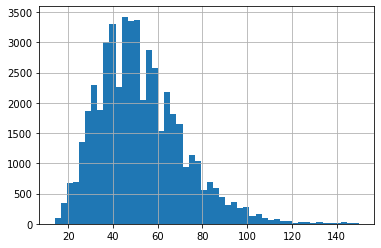

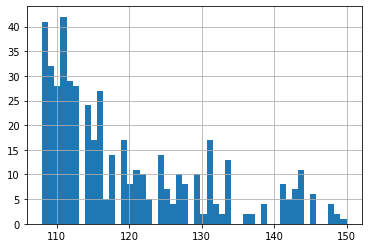

In [29]:
pd_test.intent.str.len().hist(bins=50)
plt.show()
mask = pd_test.intent.str.len() > pd_test.intent.str.len().quantile(0.99)
pd_test.intent[mask].str.len().hist(bins=50)
plt.show()

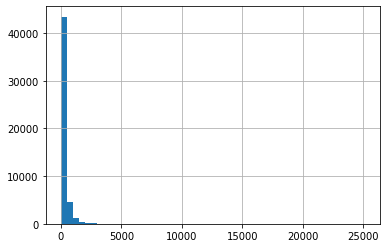

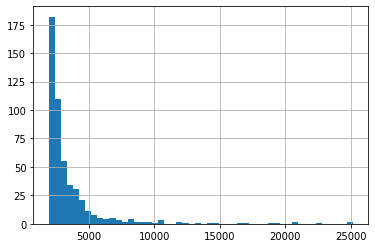

In [30]:
pd_test.snippet.str.len().hist(bins=50)
plt.show()
mask = pd_test.snippet.str.len() > pd_test.snippet.str.len().quantile(0.99)
pd_test.snippet[mask].str.len().hist(bins=50)
plt.show()

In [31]:
for i in range(5):
    print(pd_test.intent[i])
    print(f"Snoppet len: {len(pd_test.snippet[i])}")
    print(pd_test.snippet[i])
    print('------------------------------------------')

Use Python social auth to only get tokens
Snoppet len: 90

# Create a user account if we haven't found one yet.
'social.pipeline.user.create_user',

------------------------------------------
updating matplotlib imshow from within a Tkinter gui
Snoppet len: 155
def rotate(*args):
    print 'rotate button press...'
    theta = 90
    rotated = ndimage.rotate(image, theta)
    im.set_data(rotated)
    canvas.draw()

------------------------------------------
How can I verify my selfsigned certificate when using easywebdav?
Snoppet len: 242
import ssl
import os
# get the https certificate
cert = ssl.get_server_certificate(('example.com', 443))
# append it to my personal chain
pem_path = os.path.expanduser('~/.pki/CA/cacert.pem')
with open(pem_path, 'a+') as f:
    f.write(cert)

------------------------------------------
How to do write a Python script that inputs all files from a certain subdirectory from command line?
Snoppet len: 342
import sys
import os
import glob

def handle_file(fi

In [32]:
#max_len_index = pd_test.snippet.str.len().argmax()
#print(pd_test.intent[max_len_index], pd_test.snippet[max_len_index])

In [33]:
def data_cleaner(path_dir, files = ['train.csv', 'valid.csv', 'test.csv'], 
                 clean_type = 'light', len_quantile = 0.70):
    len_threshold = pd.read_csv(path_dir + files[0]).snippet.str.len().quantile(0.70)
    print(f"len_threshold = {int(len_threshold)}")
    for file in files:
        pd_data = pd.read_csv(path_dir + file)
        len_before = pd_data.shape[0]
        pd_data = pd_data[pd_data.snippet.str.len() <= len_threshold]
        pd_data.to_csv(path_dir + file[:-4] + f"_{clean_type}" + file[-4:])
        print(f"{file}: len_before = {len_before}, len_after = {pd_data.shape[0]}")

In [34]:
path_dir = './stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/'
files = ['train.csv', 'valid.csv', 'test.csv']

In [35]:
data_cleaner(path_dir, files, 
                 clean_type = 'light', len_quantile = 0.70)
print()
!ls './stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/'

len_threshold = 259
train.csv: len_before = 50000, len_after = 35006
valid.csv: len_before = 3500, len_after = 2456
test.csv: len_before = 3535, len_after = 2477

test.csv	train.csv	 valid.csv
test_light.csv	train_light.csv  valid_light.csv


In [36]:
import torch
from torchtext import data, datasets

#torchtext.legacy.data.Field - Defines a datatype together with instructions for converting to Tensor.
SRC = Field(
    tokenize = tokenize_question, #max_len = 16
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
    include_lengths = True
)

TRG = Field(
    tokenize = tokenize_snippet, #max_len = 10
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True
)

fields = {
    'intent': ('src', SRC),
    'snippet': ('trg', TRG)
}

#TabularDataset - Defines a Dataset of columns stored in CSV, TSV, or JSON format
#TabularDataset.splits - Create Dataset objects for multiple splits of a dataset.
train_data, valid_data, test_data = TabularDataset.splits(
                            path = './stepik-dl-nlp/datasets/stackoverflow_code_generation/StaQC/',
                            train = 'train_light.csv',
                            validation = 'valid_light.csv',
                            test = 'test_light.csv',
                            format = 'csv',
                            fields = fields
)

In [37]:
#.build_vocab - Construct the Vocab object for this field from one or more datasets.
#place of possible hyperparameters (max_size=25000, min_freq=3)
SRC.build_vocab([train_data.src], max_size=25000, min_freq=3)
print(SRC.vocab.freqs.most_common(20))


#place of possible hyperparameters (max_size=?, min_freq=5)
TRG.build_vocab([train_data.trg], min_freq=5)
print(TRG.vocab.freqs.most_common(20))

print(f"Первые 10 токенов: {SRC.vocab.itos[:10]}")

print(f"Уникальные токены в словаре интентов: {len(SRC.vocab)}")
print(f"Уникальные токены в словаре сниппетов: {len(TRG.vocab)}")

[('python', 15375), ('a', 14229), ('in', 13541), ('to', 12672), ('of', 7688), ('how', 7620), ('the', 5046), ('list', 4718), ('with', 4362), ('and', 3918), ('from', 3839), ('for', 2638), ('using', 2630), ('i', 2400), ('string', 2304), ('file', 2258), ('is', 2014), ('pandas', 1833), ('function', 1814), ('on', 1781)]
[(',', 81255), ('.', 79623), ('(', 77857), (')', 77766), ('=', 45936), (':', 39518), ('[', 37438), (']', 37382), ('"', 28387), ('1', 18340), ('-', 17392), ('0', 15389), ('in', 13345), ('/', 12558), ('2', 10643), ("'", 10540), ('for', 9394), ('a', 8100), ('3', 8094), ('x', 8027)]
Первые 10 токенов: ['<unk>', '<pad>', '<sos>', '<eos>', 'python', 'a', 'in', 'to', 'of', 'how']
Уникальные токены в словаре интентов: 5114
Уникальные токены в словаре сниппетов: 6859


In [38]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 35006
Размер валидационной выборки: 2456
Размер тестовой выборки: 2477


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_device(0)

In [40]:
device

device(type='cuda')

In [41]:
BATCH_SIZE = 100

'''
BucketIterator - Defines an iterator that batches examples of similar lengths together. (т.е. схожей длины, это суть выбора BucketIterator)
Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.

Итого, генерирует батчи тензоров равной длины (из индексов токенов), длина берется максимальная из примеров попавших в батч 
(если sort = True и/или sort_within_batch = True, то батчи формируются после предварительной сортировки по размеру), все примеры меньшей длины
добиваются до необходимой через токен паддинга (<pad>, id=1)

Судя по документации, sort_within_batch - отвечает только за необходимость сортировки внутри батчей, и не должен влиять на суть BucketIterator, 
а именно объединение в батчи на основе длины, но по факту влияет, если выставить False и не будет параметра sort = True, то примеры будут 
объединяться в батч рандомно, единственное, что дополнительно будет делать BucketIterator - это добивать до общей максимальной длины паддингами
(что бы убрать неоднозначности, явно добавил еще и параметр sort = True)

P.S. sort_within_batch нужно для упаковки PackedSequence, если батч не будет отсортирован по убыванию длины, то нужно при упаковке в 
PackedSequence, использовать параметр enforce_sorted = False (не изучал подробно на что это влияет)
'''
#place of possible hyperparameters (sort/sort_within_batch = True) - не факт что такое упорядочивание не скажется непонятным образом на обучении
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort = True,
     sort_within_batch = True, 
     sort_key = lambda x : len(x.src),
     device = device)

In [42]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 100
DEC_HID_DIM = 100
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

In [43]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5114, 128)
    (rnn): GRU(128, 100, bidirectional=True)
    (fc): Linear(in_features=200, out_features=100, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=300, out_features=100, bias=True)
    )
    (embedding): Embedding(6859, 128)
    (rnn): GRU(328, 100)
    (out): Linear(in_features=428, out_features=6859, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [44]:
print(f'Модель содержит {count_parameters(model):,} параметров')

Модель содержит 4,792,355 параметров


Then we define our optimizer and criterion. We have already initialized `PAD_IDX` when initializing the model, so we don't need to do it again.

In [45]:
optimizer = optim.Adam(model.parameters())

In [46]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [47]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'StaQC_model_attention_test.pt')
    
    print(f'Эпоха: {epoch+1:02} | Время: {epoch_mins}m {epoch_secs}s Перплексия (обучение): \
    {math.exp(train_loss):7.3f} Перплексия (валидация): {math.exp(valid_loss):7.3f}')

Эпоха: 01 | Время: 3m 42s Перплексия (обучение):     163.560 Перплексия (валидация): 132.038
Эпоха: 02 | Время: 3m 40s Перплексия (обучение):     102.384 Перплексия (валидация): 126.275
Эпоха: 03 | Время: 3m 40s Перплексия (обучение):      92.832 Перплексия (валидация): 121.358
Эпоха: 04 | Время: 3m 41s Перплексия (обучение):      85.325 Перплексия (валидация): 122.827
Эпоха: 05 | Время: 3m 40s Перплексия (обучение):      78.113 Перплексия (валидация): 123.728
Эпоха: 06 | Время: 3m 40s Перплексия (обучение):      72.445 Перплексия (валидация): 122.924
Эпоха: 07 | Время: 3m 41s Перплексия (обучение):      66.773 Перплексия (валидация): 121.976
Эпоха: 08 | Время: 3m 40s Перплексия (обучение):      62.437 Перплексия (валидация): 123.116
Эпоха: 09 | Время: 3m 41s Перплексия (обучение):      58.875 Перплексия (валидация): 123.687
Эпоха: 10 | Время: 3m 42s Перплексия (обучение):      56.281 Перплексия (валидация): 121.937
Эпоха: 11 | Время: 3m 42s Перплексия (обучение):      52.735 Перплекси

In [48]:
#загружаем сохраненную best_model
model.load_state_dict(torch.load('StaQC_model_attention_test.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Перплексия (валидация): {math.exp(test_loss):7.3f}')

Перплексия (валидация): 121.267


### Предсказание кода по вопросу

In [49]:
for example in train_data.examples[::3000]:

    src = ' '.join(vars(example)['src'])
    trg = ' '.join(vars(example)['trg'])

    print(f'src = {src}')
    print(f'true trg = {trg}')

    translation, attention = translate_sentence(model, src)

    print('pred trg = ', ''.join(translation))
    
    print('---------------------------------------------------------')
    print()

    #display_attention(src, translation, attention)

src = tokens get only to auth social python use
true trg = create a user account if we haven't found one yet . 'social . pipeline . user . ,
pred trg =  import=<unk>="""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
---------------------------------------------------------

src = python in parameters entering
true trg = import random parameters = [ [ 1 , 3 , 2 ] , [ 4 , 5 , 6 ] ] random . triangular ( parameters [ 0 ] ) 1 .
pred trg =  <unk>=((())))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
---------------------------------------------------------

src = python in lists unequal two of addition wise element
true trg = import itertools map ( sum , itertools . ( a , b , fillvalue = 0 ) )
pred trg =  [((((,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
---------------------------------------------------------

src = line no them make and file read the

In [50]:
for example in valid_data.examples[::100]:

    src = ' '.join(vars(example)['src'])
    trg = ' '.join(vars(example)['trg'])

    print(f'src = {src}')
    print(f'true trg = {trg}')

    translation, attention = translate_sentence(model, src)

    print('pred trg = ', ''.join(translation))
    
    print('---------------------------------------------------------')
    print()

    #display_attention(src, translation, attention)

src = members static 3 python
true trg = @ def ( ) : if username is none : . . .
pred trg =  def=(()))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
---------------------------------------------------------

src = lists the in values of mapping of sequence the maintaining by lists two randomize
true trg = list1 ( 'item4' , 'item3' , 'item1' , 'item2' ) list2 ( 'label4' , 'label3' , 'label1' , 'label2' )
pred trg =  foriin[((),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
---------------------------------------------------------

src = string revers to php in loop for like python's use i can how
true trg = output = c . output ;
pred trg =  <unk>=(((()))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
---------------------------------------------------------

src = column another in value by grouped column a in values up sum to need csv python
true trg = (

In [51]:
for example in test_data.examples[::100]:

    src = ' '.join(vars(example)['src'])
    trg = ' '.join(vars(example)['trg'])

    print(f'src = {src}')
    print(f'true trg = {trg}')

    translation, attention = translate_sentence(model, src)

    print('pred trg = ', ''.join(translation))
    
    print('---------------------------------------------------------')
    print()

    #display_attention(src, translation, attention)

src = case letter ignore python
true trg = rules . lower ( ) = = rulesa . lower ( )
pred trg =  <unk>=[((((),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
---------------------------------------------------------

src = 7 2 python in object same the to pointing all dictionary level two a of values are why
true trg = ( tier1 , tier2 , lambda : " i am shared but immutable " )
pred trg =  <unk>=[((),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
---------------------------------------------------------

src = python in range character unicode detect to how
true trg = def ( line ) : maxchar = max ( line ) if u' \ u0c00' = maxchar = u' \ u0c7f' : return 'telugu' elif u' \ u0900' = maxchar = u' \ u097f' : return 'hindi' return 'english'
pred trg =  <unk>=((())))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
----------------------------------------------------